927/927 - 31s - loss: 9.9647e-04 - 31s/epoch - 34ms/step
8/8 [==============================] - 1s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

<ipython-input-12-d2a932709a11>:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



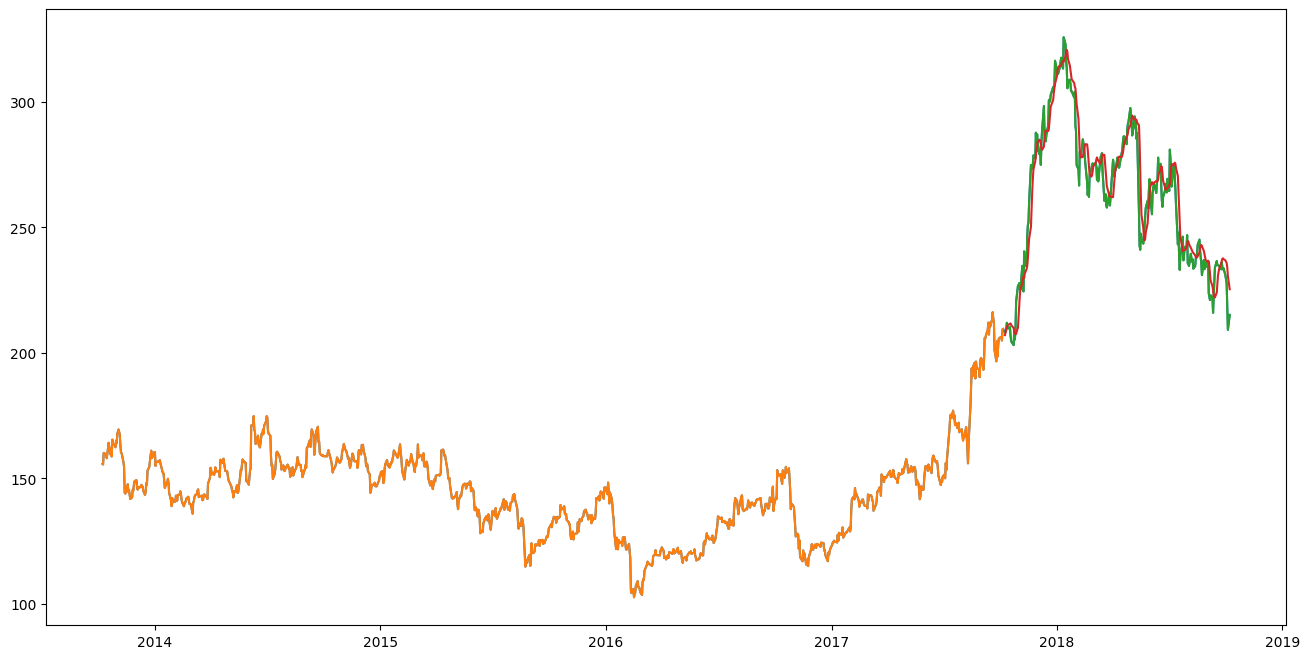

In [ ]:
# -*- coding: utf-8 -*-
"""stock_pred.ipynb

Automatically generated by Colaboratory.


# Stock price prediction using LSTM

### Imports
"""
#%%
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# %matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
#%%
"""### Read the dataset:"""

df=pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df.head()
#%%
"""### Analyze the closing prices from dataframe:"""

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

"""### ort the dataset on date time and filter “Date” and “Close” columns:"""
#%%
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
#%%
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]


new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
#%%
"""### Normalize the new filtered dataset:"""

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
#%%
"""### Build and train the LSTM model:"""

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
#%%
"""### Take a sample of a dataset to make stock price predictions using the LSTM model:"""

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
#%%
"""### Save the LSTM model:"""

lstm_model.save("saved_model.h5")
#%%
"""### Visualize the predicted stock costs with actual stock costs:"""

train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [ ]:
!pip install dash
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np


app = dash.Dash()
server = app.server

scaler=MinMaxScaler(feature_range=(0,1))



df_nse = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")

df_nse["Date"]=pd.to_datetime(df_nse.Date,format="%Y-%m-%d")
df_nse.index=df_nse['Date']


data=df_nse.sort_index(ascending=True,axis=0)
new_data=pd.DataFrame(index=range(0,len(df_nse)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_data["Date"][i]=data['Date'][i]
    new_data["Close"][i]=data["Close"][i]

new_data.index=new_data.Date
new_data.drop("Date",axis=1,inplace=True)

dataset=new_data.values

train=dataset[0:987,:]
valid=dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

x_train,y_train=[],[]

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

model=load_model("saved_model.h5")

inputs=new_data[len(new_data)-len(valid)-60:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)

X_test=[]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

train=new_data[:987]
valid=new_data[987:]
valid['Predictions']=closing_price



df= pd.read_csv("stock_data.csv")

app.layout = html.Div([

    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),

    dcc.Tabs(id="tabs", children=[

        dcc.Tab(label='NSE-TATAGLOBAL Stock Data',children=[
			html.Div([
				html.H2("Actual closing price",style={"textAlign": "center"}),
				dcc.Graph(
					id="Actual Data",
					figure={
						"data":[
							go.Scatter(
								x=train.index,
								y=valid["Close"],
								mode='markers'
							)

						],
						"layout":go.Layout(
							title='scatter plot',
							xaxis={'title':'Date'},
							yaxis={'title':'Closing Rate'}
						)
					}

				),
				html.H2("LSTM Predicted closing price",style={"textAlign": "center"}),
				dcc.Graph(
					id="Predicted Data",
					figure={
						"data":[
							go.Scatter(
								x=valid.index,
								y=valid["Predictions"],
								mode='markers'
							)

						],
						"layout":go.Layout(
							title='scatter plot',
							xaxis={'title':'Date'},
							yaxis={'title':'Closing Rate'}
						)
					}

				)
			])


        ]),
        dcc.Tab(label='Tech Giants Stock Data', children=[
            html.Div([
                html.H1("Stocks High vs Lows",
                        style={'textAlign': 'center'}),

                dcc.Dropdown(id='my-dropdown',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'},
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}],
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto",
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='highlow'),
                html.H1("Stocks Market Volume", style={'textAlign': 'center'}),

                dcc.Dropdown(id='my-dropdown2',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'},
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}],
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto",
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume')
            ], className="container"),
        ])


    ])
])







@app.callback(Output('highlow', 'figure'),
              [Input('my-dropdown', 'value')])
def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7,
                     name=f'High {dropdown[stock]}',textposition='bottom center'))
        trace2.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1',
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Price (USD)"})}
    return figure


@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])
def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1',
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Transactions Volume"})}
    return figure



if __name__=='__main__':
	app.run_server(debug=True)